### This notebook is used for illustrating raster plot of PV recordings.
To do list:
- [x] Load Ca2+ events (DSC012019-200806)
- [x] Raster plot with GPIOs
- [x] Sort data wtih GPIOs
- [x] Plot individual event rate with parallel coordinates
- [ ] Plot individual event rate color-coded with activations intensity

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#plt.style.use('seaborn')
import seaborn as sns

import os
import glob

import datetime

import numpy as np
import pandas as pd
import math
from random import randrange
from random import randint


Bad key "text.kerning_factor" on line 4 in
/Users/hunglo/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
## Helper functions

## Def phensys converter for lick rate
def timestampconvert(x):
  stamp = datetime.timedelta(days = x)
  result = datetime.datetime(1899,12,30,0,0) + stamp
  # print(result.strftime('%Y-%m-%d %H:%M:%S.%f'))
  return result

def datetime_convert_phenosys(csv_path):
    df_pheno = pd.read_csv(csv_path)
    time_list = df_pheno['DateTime']
    result = []
    for x in time_list:
        timestampconvert(x)
        result.append(timestampconvert(x))
    new_time_stamps = []
    for i in result:
        new_time_stamps.append((i-min(result)).total_seconds())
    df_pheno = df_pheno.fillna(0)
    df_pheno['DateTime'] = new_time_stamps
    # df_pheno
    return df_pheno

## Function for getting L1 and L2 lick events
def lick_event_calculate(csv_path):
    """
    This function will calcuate the lick sensor data from the phenosys csv files and return 3 lists of timestamps from sensor L1, L2 and the timestamps of both channels. It will also do a quick plotting for the lick sensor data for raster plots and the density plot of overall lick events.

    """
    df = datetime_convert_phenosys(csv_path)
    
    # Get L1 timestamps and MsgValue1
    L1_time = df[df['unitLabel']=='L1']['DateTime'].values
    L1_value = df[df['unitLabel']=='L1']['MsgValue1'].values

    L1_timestamps_new = []
    for idx,value in enumerate(L1_value):
        if len(value.split(','))>1:
            # print(value.split(','))
            for j in value.split(',')[1:]:
                # print(j.split('-')[0])
                individual_value = int(j.split('-')[0])*0.001 # convert ms to s
                # print(L1_time[idx]+individual_value)
                if idx == 0:
                    L1_timestamps_new.append(L1_time[idx]+individual_value)
                else:
                    L1_timestamps_new.append(L1_timestamps_new[-1]+individual_value)
        else:
            L1_timestamps_new.append(L1_time[idx])

    ## The same for L2
    L2_time = df[df['unitLabel']=='L2']['DateTime'].values
    L2_value = df[df['unitLabel']=='L2']['MsgValue1'].values

    L2_timestamps_new = []
    for idx,value in enumerate(L2_value):
        if len(value.split(','))>1:
            # print(value.split(','))
            for j in value.split(',')[1:]:
                # print(j.split('-')[0])
                individual_value = int(j.split('-')[0])*0.001
                # print(L1_time[idx]+individual_value)
                if idx == 0:
                    L2_timestamps_new.append(L2_time[idx]+individual_value)
                else:
                    L2_timestamps_new.append(L2_timestamps_new[-1]+individual_value)
        else:
            L2_timestamps_new.append(L2_time[idx])

    all_lick_events = sorted(L1_timestamps_new + L2_timestamps_new)

    print('File processed: '+csv_path.split('/')[-1])
    print('Is there any duplication?: '+ str(len(L1_timestamps_new) != len(set(L1_timestamps_new))))

    fig, [ax0,ax1] = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=[8,4])
    ax0.eventplot([L1_timestamps_new,L2_timestamps_new,all_lick_events],lw=0.5,linelengths=0.8,color=['C0','C1','C3'])
    legend=ax0.legend(['L1','L2','All'],bbox_to_anchor=(0., 1.1, 1., 1.1), loc=3, ncol=3, mode="expand", 
                borderaxespad=0.,frameon=False,title='Lick events for L1 & L2 lick sensors: '+csv_path.split('/')[-1],fontsize=8)
    
    legend.get_title().set_fontsize('9')
    
    # sns.distplot(L1_timestamps_new, hist=False, rug=True, ax=ax1, color='C0',rug_kws={"height":0.2,"linewidth":0.5,"alpha":0.5})
    # sns.distplot(L2_timestamps_new, hist=False, rug=True, ax=ax1, color='C1',rug_kws={"height":0.2,"linewidth":0.5,"alpha":0.5})
    sns.distplot(all_lick_events, hist=False, rug=True, ax=ax1, color='C3',rug_kws={"height":0.2,"linewidth":0.5,"alpha":0.5})
    ax0.set_yticks([])
    ax1.set_yticks([])
    plt.xlabel('Second',fontsize=8)
    plt.xticks(fontsize=8);plt.yticks(fontsize=8)
    plt.xlim([0,1600])
    plt.tight_layout();plt.show()
    return L1_timestamps_new, L2_timestamps_new, all_lick_events



## Function for getting P1 and P1C lick events
def GPIO_event_calculate(csv_path):
    """
    This function will calcuate the lick sensor data from the phenosys csv files and return 3 lists of timestamps from GPIOs P1 and P1C and the timestamps of both channels.

    """
    df = datetime_convert_phenosys(csv_path)
    
    # Get L1 timestamps and MsgValue1
    P1_time = df[df['unitLabel']=='P1']['DateTime'].values
    P1C_time = df[df['unitLabel']=='P1C']['DateTime'].values
    
    P2_time = df[df['unitLabel']=='P2']['DateTime'].values
    P2A_time = df[df['unitLabel']=='P2A']['DateTime'].values

    # all_pump_events = P1_time + P1C_time + P2_time + P2A_time
    pump_all = np.concatenate([P1_time,P1C_time,P2_time,P2A_time],axis=0)
    pump_all = sorted(pump_all)
    pump_all = np.array(pump_all)

    # fig, ax0 = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=[8,2])
    # ax0.eventplot([P1_time,P1C_time,P2_time,P2A_time],lw=0.5,linelengths=0.8,color=['C0','C1','C3','C4'])
    # legend=ax0.legend(['P1','P1C','P2','P2A'],bbox_to_anchor=(0., 1.1, 1., 1.1), loc=3, ncol=4, mode="expand", 
    #             borderaxespad=0.,frameon=False,title='GPIO events: '+csv_path.split('/')[-1],fontsize=8)
    
    # legend.get_title().set_fontsize('9')
    
    # ax0.set_yticks([])
    # plt.xlabel('Second',fontsize=8)
    # plt.xticks(fontsize=8);plt.yticks(fontsize=8)
    # plt.xlim([0,1600])
    # plt.tight_layout();plt.show()
    
    return P1_time, P1C_time, P2_time, P2A_time, pump_all

## Filter function for np array
def filter_mask_large(arr, j):
    return arr[arr < j]
def filter_mask_small(arr, k):
    return arr[arr > k]

## find nearst value in np array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


In [3]:
## Plotting setting
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 10})


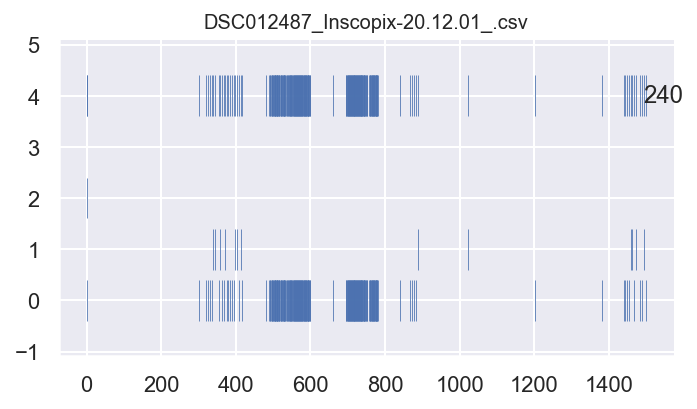

In [65]:
## Load GPIO data with GPIO_event_calculate() function.

## which mouse?
mouse_id = 'DSC012487'

# Locate file folder
GPIO_folder = '/Users/hunglo/Desktop/GPIO_phenosys_log_file/'+mouse_id+'/processed/'

extension = 'csv'
os.chdir(GPIO_folder)
result = sorted(glob.glob('*.{}'.format(extension)))
# print(result)

idx = 3
P1, P1C, P2, P2A, Pump_all = GPIO_event_calculate(GPIO_folder+result[idx])

plt.figure(figsize=[5,3])
plt.title(result[idx],fontsize=10)
plt.eventplot(Pump_all,lineoffsets = 4,linelengths = 0.8,linewidths=0.4)
plt.eventplot([P1,P1C,P2,P2A],linelengths = 0.8,linewidths=0.4)
plt.text(s=len(Pump_all),x=1600,y=4,va='center',ha='right')
sns.despine()
plt.tight_layout()

In [125]:
# ## Load Ca2+ event data, align time differences
# event_folder = '/Users/hunglo/Desktop/3rd_supervision/Ca2_trace_csv/CNMFe_pnr10_mincorr08_PV/'+mouse_id
# extension = 'csv'
# os.chdir(event_folder)
# result_event = sorted(glob.glob('*.{}'.format(extension)))
# print(result_event)


In [68]:
## Load Ca2+ event
event_path = '/Users/hunglo/Desktop/3rd_supervision/Ca2_trace_csv/CNMFe_pnr10_mincorr08_PV/DSC012487/DSC012487201201_celltraces_ED.csv'
df_event=pd.read_csv(event_path, header=0,skiprows=[1],index_col=0)
df_event.head()

## Load Inscopix_GPIO to align Ca2+ data with phenosys
file_path = event_path[0:-17]+'GPIO.csv'
sheet=pd.read_csv(file_path, header=[0], index_col=0)
gpiosub=sheet.loc[sheet[' Channel Name']== ' GPIO-1']
Inscopix_GPIO_init = gpiosub[' Value'][300:315].astype(float).idxmin()
# Inscopix_GPIO_init

# Calculate time difference
if len(P1) == 1:
    if np.min(abs(find_nearest(P2,300)-300)) > np.min(abs(find_nearest(P2A,300)-300)):
        time_diff = Inscopix_GPIO_init - find_nearest(P2A,300)
    else:
        time_diff = Inscopix_GPIO_init - find_nearest(P2,300)
else:
    if abs(find_nearest(P1,300)-300) > abs(find_nearest(P1C,300)-300):
        time_diff = Inscopix_GPIO_init - find_nearest(P1C,300)
    else:
        time_diff = Inscopix_GPIO_init - find_nearest(P1,300)
print(time_diff)

# Pivot the dataframe for all time stamps for easy handling
df_spike_binary = df_event.pivot(columns=' Cell Name',values=' Value').fillna(0)
df_spike_binary[df_spike_binary>0] = 1 # Make deconvoluted values to 1
df_spike_binary.index = df_spike_binary.index-time_diff
df_spike_binary


9.959996000000046


Cell Name,C0,C1,C10,C11,C12,C13,C14,C15,C16,C17,...,C30,C31,C32,C33,C4,C5,C6,C7,C8,C9
Time (s),,,,,,,,,,,,,,,,,,,,,
-9.910035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9.860074,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9.710191,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9.660230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9.610269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809.469741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1810.768727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1812.267557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


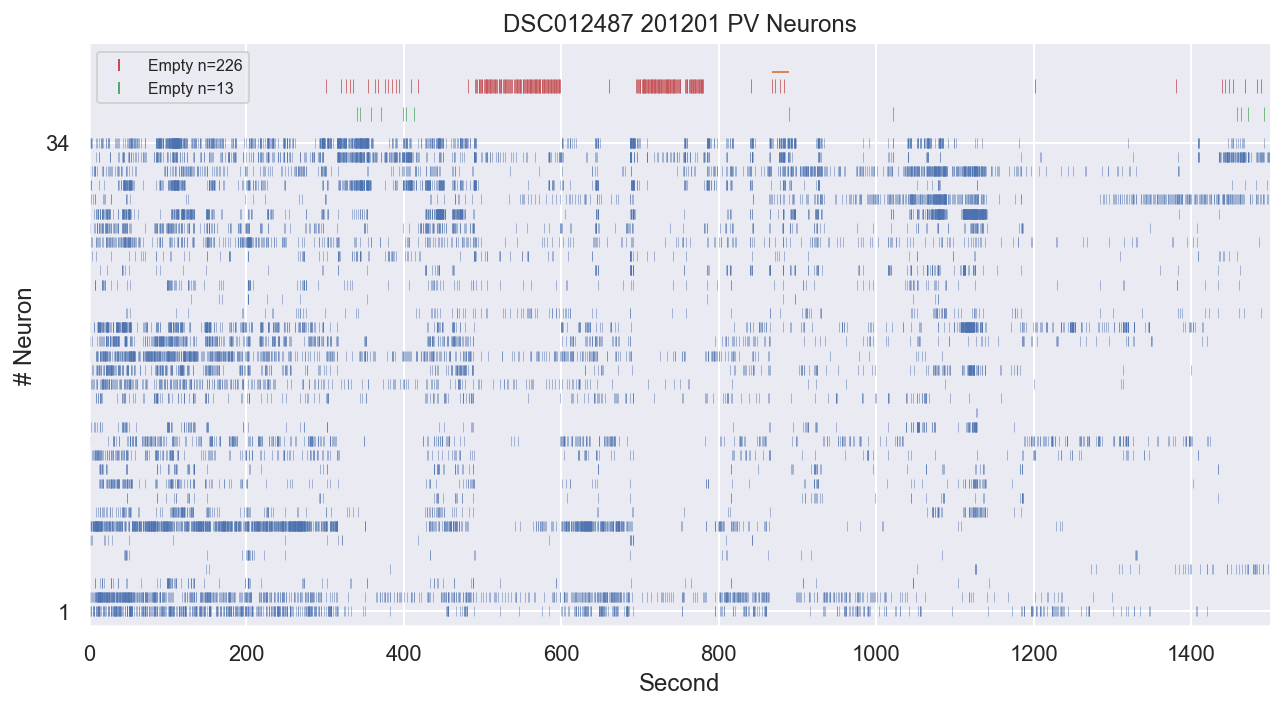

In [69]:
## Plotting setting
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 10})

# Define sorting run

sort_run = 4
baseline = 300
interrun_interval = 60

xmin = baseline + (sort_run-1)*180
xmax = xmin + 120
# print(xmin,xmax)

GPIO_filtered = filter_mask_small(filter_mask_large(Pump_all,xmax),xmin)

xmin_sort = GPIO_filtered[1]
xmax_sort = GPIO_filtered[-1]

spike_count = df_spike_binary.loc[xmin_sort:xmax_sort,:].sum().values
isort = np.argsort(spike_count)
sorted_cell_name = df_spike_binary.columns[isort]
df_spike_sorted = df_spike_binary.reindex(columns=sorted_cell_name)

# Strings setups
date = event_path.split('/')[-1].split('_')[0][-6:]
title = mouse_id+' '+date+' PV Neurons'
plot_name = mouse_id+'_'+date+'_PV_'

# Initiate plotting
fig, ax = plt.subplots(figsize=[9,5])

if P1 != []:
    GPIO_plot = [P1,P1C]
    deliver_milk = len(P1)
    deliver_water = len(P1C)
else:
    GPIO_plot = [P2,P2A]
    deliver_milk = len(P2)
    deliver_water = len(P2A)

y_offset = df_spike_binary.shape[-1]+2
ax.eventplot(GPIO_plot,color=['C3','C2'],lineoffsets=[y_offset+2,y_offset],linewidths=0.5,linestyle = 'None',alpha=0.75)

for i,name in enumerate(df_spike_sorted.columns):
    data=df_spike_sorted[name][df_spike_sorted[name] > 0]
    ax.eventplot(data.index.values,lineoffsets = i+1,linewidth=0.3,linelength=0.7,alpha=0.75)

# Plot sorted period
ax.hlines(xmin=xmin_sort,xmax=xmax_sort,y=y_offset+3,linewidth=1,color='C1')

## Aesthetic & lables
# legend_hidden_line_red = mlines.Line2D([], [], color='C3', markersize=6, marker='|',label='Strawberry milk n='+str(deliver_milk),linestyle='')
# legend_hidden_line_green = mlines.Line2D([], [], color='C2', markersize=6, marker='|',label='Water n='+str(deliver_water),linestyle='')

legend_hidden_line_red = mlines.Line2D([], [], color='C3', markersize=6, marker='|',label='Empty n='+str(deliver_milk),linestyle='')
legend_hidden_line_green = mlines.Line2D([], [], color='C2', markersize=6, marker='|',label='Empty n='+str(deliver_water),linestyle='')
plt.legend(handles=[legend_hidden_line_red, legend_hidden_line_green],fontsize=8,loc=2)

sns.despine()

plt.xlabel('Second')
plt.ylabel('# Neuron')
plt.yticks([1,df_spike_binary.shape[-1]])
plt.xlim(xmin=-10)
plt.ylim(ymin=0)
plt.title(title)
plt.xlim([0,1500])
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/Ca2_plot/rasterplot_'+plot_name+'.pdf',dpi=300,transparent=True)

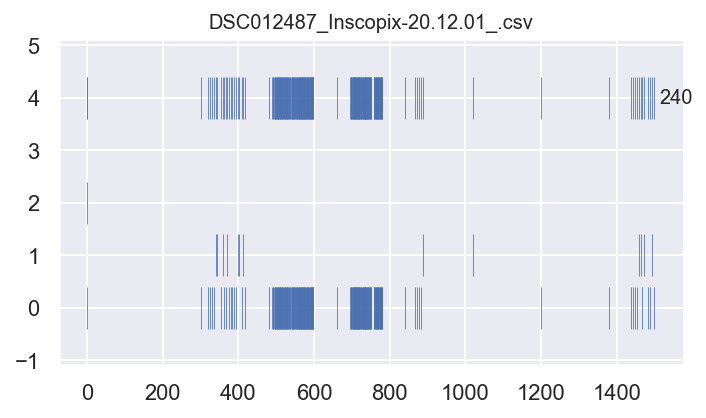

In [70]:
plt.figure(figsize=[5,3])
plt.title(result[idx],fontsize=10)
plt.eventplot(Pump_all,lineoffsets = 4,linelengths = 0.8,linewidths=0.4)
plt.eventplot([P1,P1C,P2,P2A],linelengths = 0.8,linewidths=0.4)
plt.text(s=len(Pump_all),x=1600,y=4,va='center',ha='right')
sns.despine()
plt.tight_layout()

In [71]:
## Convert P2/P2A to dataframe
GPIO1_df = pd.DataFrame([P1,np.ones(len(P1))]).T
GPIO1_df.columns = ['timestamps', 'value']
GPIO1_df = GPIO1_df.set_index('timestamps')
GPIO1C_df = pd.DataFrame([P1C,np.ones(len(P1C))]).T
GPIO1C_df.columns = ['timestamps', 'value']
GPIO1C_df = GPIO1C_df.set_index('timestamps')

binging_round_time = [GPIO1_df[450:600].index.values[1], # remove initial pump activation
                      GPIO1_df[450:600].index.values[-1]]
# binging_round_time = [GPIO1_df[600:800].index.values[1], # remove initial pump activation
#                       GPIO1_df[600:800].index.values[-1]]
# binging_round_time = [GPIO1_df[800:1000].index.values[1], # remove initial pump activation
#                       GPIO1_df[800:1000].index.values[-1]]

binging_round_time

# Get the last timestamp before binging
# s_lick_p1_1 = GPIO1_df[300:450].index.values[0:]
# s_lick_p1_1[-1]

[490.309002, 598.330006]

In [72]:
## Calculate event rate

## Event calculation before and upon binging 1
baseline_time = [0,300]
# pre_binge = [s_lick_p1_1[-1],binging_round_time[0]]
binge = binging_round_time

data = df_spike_binary.copy()

baseline_fr = data[baseline_time[0]:baseline_time[1]].sum().values/(baseline_time[1]-baseline_time[0])

# pre_binge_fr = data[pre_binge[0]:pre_binge[1]].sum().values/(pre_binge[1]-pre_binge[0])

binge_fr = data[binge[0]:binge[1]].sum().values/(binge[1]-binge[0])


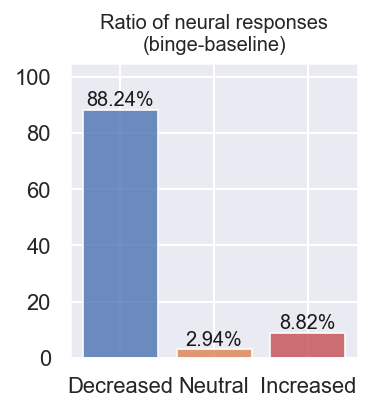

In [73]:
## Bar plots for event difference

pre = baseline_fr
post = binge_fr

# pre = pre_binge_fr
# post = binge_fr

difference = post-pre

num_increase = len(difference[difference>0])/len(difference)*100
num_neutral = len(difference[difference==0])/len(difference)*100
num_decrease = len(difference[difference<0])/len(difference)*100
ration_list = []
ration_list.append(num_increase)
ration_list.append(num_neutral)
ration_list.append(num_decrease)

df_ratio = pd.DataFrame([num_decrease,num_neutral,num_increase],index=['Decreased','Neutral','Increased'])

## Initiate plotting
sns.set()

color = ['C0','C1','C3']
plt.figure(figsize=[2.75,3])

plt.bar(df_ratio.reset_index()['index'],df_ratio.reset_index()[0],color=color,alpha=0.8)

plt.text(x=0,y=num_decrease,s=str(np.round(num_decrease,2))+'%',fontsize=10,ha='center',va='bottom',color='k')
plt.text(x=1,y=num_neutral,s=str(np.round(num_neutral,2))+'%',fontsize=10,ha='center',va='bottom',color='k')
plt.text(x=2,y=num_increase,s=str(np.round(num_increase,2))+'%',fontsize=10,ha='center',va='bottom',color='k')

plt.ylim([0,105])
# plt.ylim([0,90])

# plt.title('Ratio of neural responses\n(binge-interval)',fontsize=10)
plt.title('Ratio of neural responses\n(binge-baseline)',fontsize=10)

plt.tight_layout()

# plt.savefig('/Users/hunglo/Desktop/3rd_supervision/bar_plots/barplot_BES0224200818_pre.pdf',dpi=300,transparent=False)
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/bar_plots/barplot_PV_baseline.pdf',dpi=300,transparent=False)
